### Simplify declaration

#### Continuous system

In [1]:
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem

# Define a new symbolic Variable
x = Variable("x")

# Define the System.  
continuous_vector_system = SymbolicVectorSystem(state=[x], dynamics=[-x + x**3], output=[x])

#### Discrete system

In [2]:
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem

# Define a new symbolic Variable
x = Variable("x")

# Define the System.  Note the additional argument specifying the time period.
discrete_vector_system = SymbolicVectorSystem(state=[x], dynamics=[x**3], output=[x], time_period=1.0)

### Declare the system of equations

In [3]:
from pydrake.systems.framework import LeafSystem

# Define the system.
class SimpleContinuousTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareContinuousState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.

    # xdot(t) = -x(t) + x^3(t)
    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        xdot = -x + x**3
        derivatives.get_mutable_vector().SetAtIndex(0, xdot)

# Instantiate the System
continuous_system = SimpleContinuousTimeSystem()


# Define the system.
class SimpleDiscreteTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareDiscreteState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=1.0,  # One second time step.
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.

    # x[n+1] = x^3[n]
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().GetAtIndex(0)
        x_next = x**3
        discrete_state.get_mutable_vector().SetAtIndex(0, x_next)

# Instantiate the System
discrete_system = SimpleDiscreteTimeSystem()

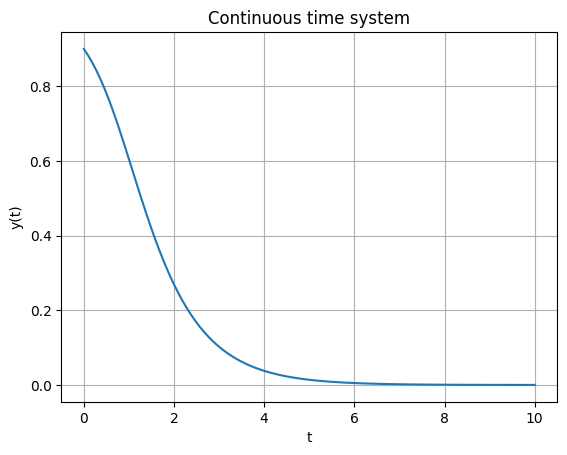

In [4]:
import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(SimpleContinuousTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.9])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Continuous time system')
plt.grid()

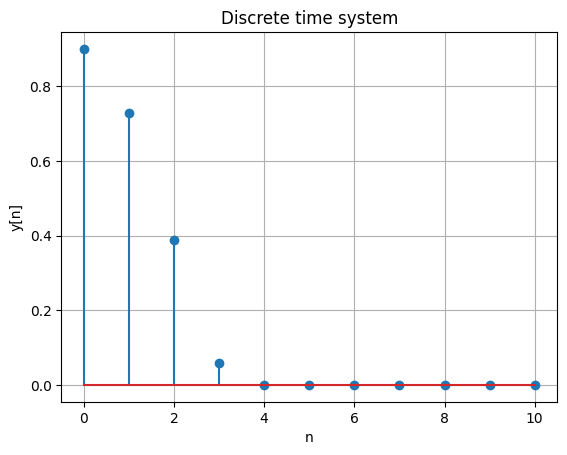

In [5]:
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(SimpleDiscreteTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Create the simulator.
simulator = Simulator(diagram)

# Set the initial conditions, x(0).
state = simulator.get_mutable_context().get_mutable_discrete_state_vector()
state.SetFromVector([0.9])

# Simulate for 10 seconds.
simulator.AdvanceTo(10)

# Plot the results.
log = logger.FindLog(simulator.get_context())
plt.figure()
plt.stem(log.sample_times(), log.data().transpose())
plt.xlabel('n')
plt.ylabel('y[n]')
plt.title('Discrete time system')
plt.grid()

### Diagram Builder

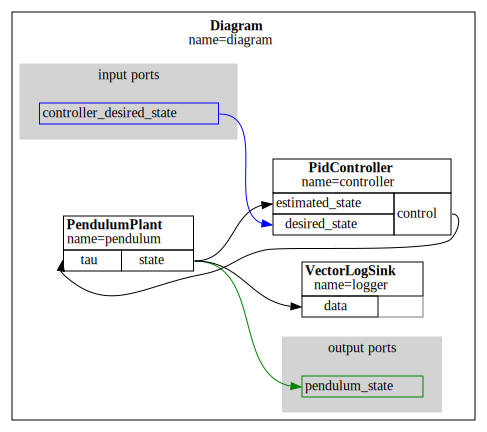

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.examples import PendulumPlant
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import PidController
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

builder = DiagramBuilder()

# First add the pendulum.
pendulum = builder.AddNamedSystem("pendulum", PendulumPlant())

# Add a PID controller.
controller = builder.AddNamedSystem("controller",
                                    PidController(kp=[10.], ki=[1.], kd=[1.]))

# Now "wire up" the controller to the plant.
builder.Connect(pendulum.get_state_output_port(),
                controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port_control(), pendulum.get_input_port())

# Make the desired_state input of the controller an input to the diagram.
builder.ExportInput(controller.get_input_port_desired_state())
# Make the pendulum state an output from the diagram.
builder.ExportOutput(pendulum.get_state_output_port())

# Log the state of the pendulum.
logger = LogVectorOutput(pendulum.get_state_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the diagram.
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

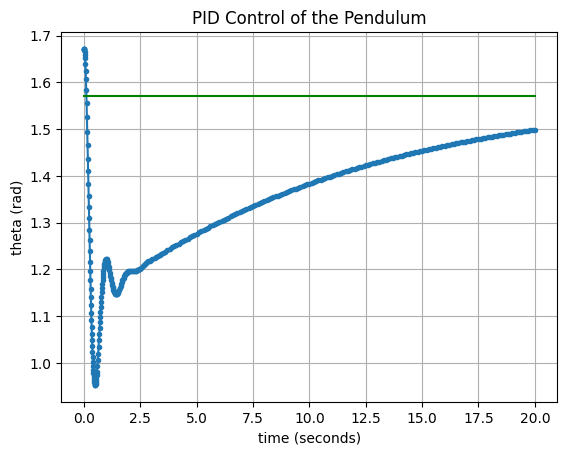

In [5]:
# Set up a simulator to run this diagram.
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# We'll try to regulate the pendulum to a particular angle.
desired_angle = np.pi/2

# First we extract the subsystem context for the pendulum.
pendulum_context = diagram.GetMutableSubsystemContext(pendulum, context)
# Then we can set the pendulum state, which is (theta, thetadot).
pendulum_context.get_mutable_continuous_state_vector().SetFromVector(
    [desired_angle + 0.1, 0.2])

# The diagram has a single input port (port index 0), which is the desired_state.
diagram.get_input_port(0).FixValue(context, [desired_angle, 0.])

# Clear the logger only because we've written this notebook with the opportunity to
# simulate multiple times (in this cell) using the same logger object.  This is
# often not needed.
logger.FindMutableLog(context).Clear()

# Simulate for 20 seconds.
simulator.AdvanceTo(20)

# Plot the results.
log = logger.FindLog(simulator.get_context())
t = log.sample_times()
plt.figure()
# Plot theta.
plt.plot(t, log.data()[0,:],'.-')
# Draw a line for the desired angle.
plt.plot([t[0], t[-1]], [desired_angle, desired_angle], 'g' )
plt.xlabel('time (seconds)')
plt.ylabel('theta (rad)')
plt.title('PID Control of the Pendulum')
plt.grid(True)